In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


# Set random seed
seed = 0



In [2]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_encoded.csv', sep='|')

In [3]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Columns: 635 entries, num__budget to category
dtypes: float64(634), object(1)
memory usage: 42.6+ MB
None
   num__budget  num__revenue  num__popularity  num__runtime  num__vote_count  \
0     4.757463      1.005269         0.425819      0.448734         1.716450   
1     2.894642      1.159981         0.366180     -0.230573         1.636140   
2     3.826052      2.100421         0.503760      0.739865         1.420090   
3     2.628524      0.670763         0.183190     -0.230573         1.375134   
4     1.510832      0.743000         0.159881     -0.085007         0.961366   

   num__release_year  num__release_month  cat__original_language_ar  \
0           0.483259           -0.241059                        0.0   
1           0.605583           -0.533445                        0.0   
2           0.789068           -0.241059                        0.0   
3           0.727906            0.343713               

# Scoring prediction

In [4]:
X = df.drop('category', axis=1)
Y = df['category']

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)


print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  7027
Test set size:  1757


## Random Forest

In [6]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)

rf_model.fit(X_train, Y_train)

RandomForestClassifier(random_state=0)

In [7]:
Y_pred = rf_model.predict(X_test)

In [8]:
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6830


In [9]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         bad       0.92      0.77      0.84       450
        good       0.54      0.61      0.57       430
       great       0.72      0.70      0.71       429
    mediocre       0.61      0.65      0.63       448

    accuracy                           0.68      1757
   macro avg       0.70      0.68      0.69      1757
weighted avg       0.70      0.68      0.69      1757



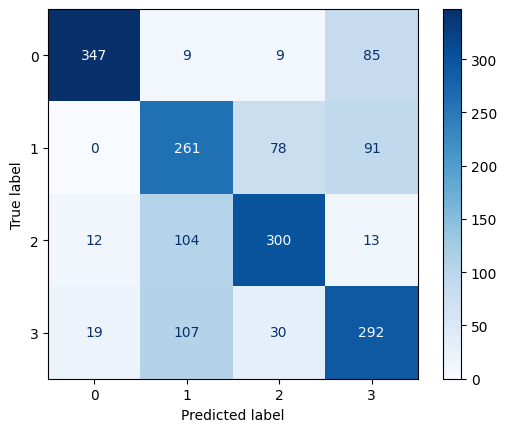

In [11]:
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [12]:
all_feature_names = X.columns

# Ensure that all_feature_names length matches feature_importances length
# This assumes that you have fitted the Random Forest model and have access to its feature importances
# Replace `rf_model` with your actual Random Forest model instance

print(f"Length of feature names: {len(all_feature_names)}")
print(f"Length of feature importances: {len(rf_model.feature_importances_)}")

# Create DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_model.feature_importances_
})

# Sort the DataFrame by feature importance
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the result
print(feature_importances_df)

Length of feature names: 634
Length of feature importances: 634
                           feature  importance
4                  num__vote_count    0.146778
2                  num__popularity    0.056803
3                     num__runtime    0.052184
5                num__release_year    0.049099
1                     num__revenue    0.044408
..                             ...         ...
19       cat__original_language_fi    0.000000
374   production_countries__arabia    0.000000
369  production_countries__algeria    0.000000
28       cat__original_language_la    0.000000
30       cat__original_language_nb    0.000000

[634 rows x 2 columns]


In [14]:
# Print 50 most important features that contain 'cast'
print(feature_importances_df[feature_importances_df['feature'].str.startswith('cast')].head(10))

                feature  importance
493   cast__frankwelker    0.000836
519   cast__keanureeves    0.000787
507     cast__jimmystar    0.000737
563   cast__willemdafoe    0.000601
499       cast__jackson    0.000600
515            cast__jr    0.000569
503   cast__jeffbennett    0.000532
528  cast__michaelcaine    0.000526
534   cast__nicolascage    0.000515
472    cast__benaffleck    0.000511


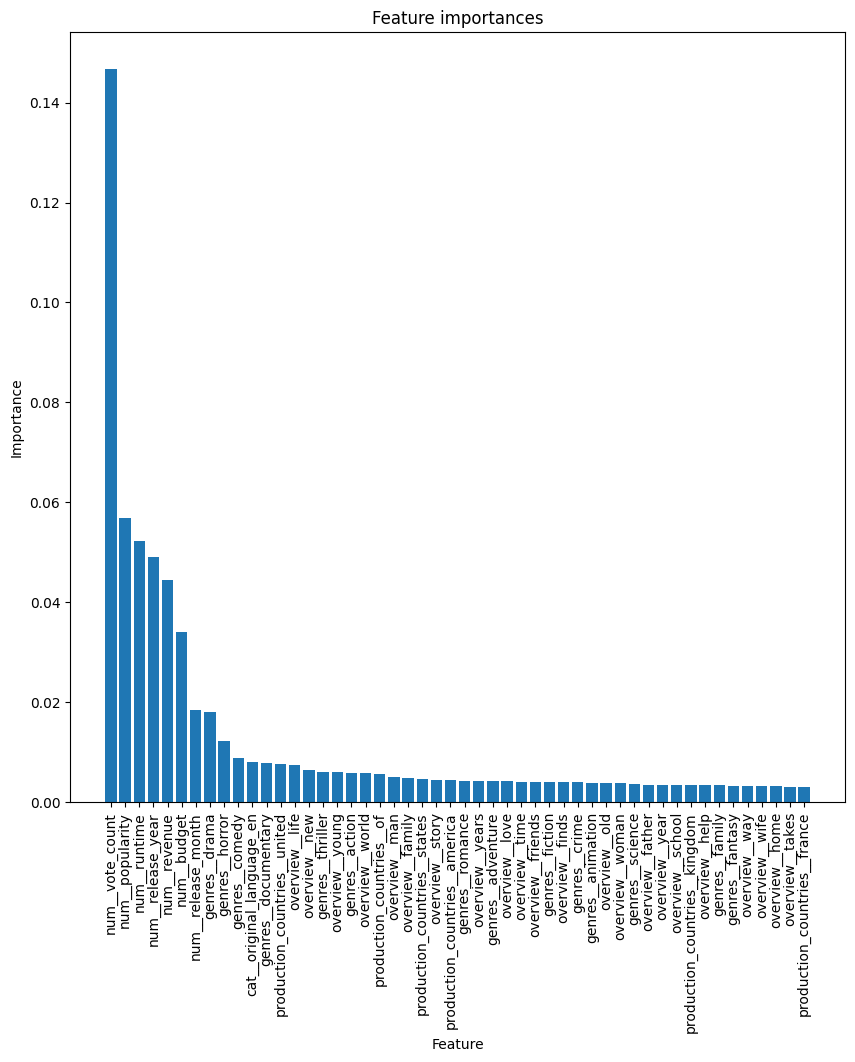

In [15]:
# plot as bars first 50 feature importances
plt.figure(figsize=(10, 10))
plt.bar(range(50), feature_importances_df['importance'][:50], align='center')
plt.xticks(range(50), feature_importances_df['feature'][:50], rotation=90)
plt.title('Feature importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

#### Wrapper to tune parameters - GridSearch

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['sqrt', 'log2'],          
    'max_depth': [10, 20, 50, None],                   
    'min_samples_split': [2, 5, 10],                    
    'min_samples_leaf': [1, 2, 4],                     
    'bootstrap': [True, False]                         
}

In [17]:
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    scoring='accuracy', 
    cv=5, 
    verbose=2, 
    n_jobs=-1
)

In [18]:
grid_search.fit(X_train, Y_train)

print("Melhores parâmetros:", grid_search.best_params_)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total ti

/usr/local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  46.9s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   7.2s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   7.0s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  11.5s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   9.7s
[CV] END bootstrap=True, max_depth=50, max_f

/usr/local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1440 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
694 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/site-packages/sklearn/ut

Melhores parâmetros: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


In [19]:
best_rf_model = grid_search.best_estimator_
Y_pred = best_rf_model.predict(X_test)

In [20]:
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7103


In [21]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         bad       0.95      0.79      0.86       450
        good       0.57      0.63      0.60       430
       great       0.75      0.71      0.73       429
    mediocre       0.63      0.70      0.67       448

    accuracy                           0.71      1757
   macro avg       0.73      0.71      0.71      1757
weighted avg       0.73      0.71      0.72      1757



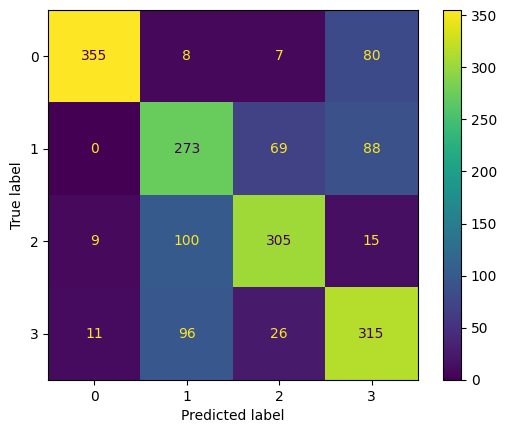

In [22]:
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()